In [2]:
import geopandas as gpd
import pandas as pd

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report, RocCurveDisplay, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

import matplotlib.pyplot as plt
import seaborn as sns

import shap 
import warnings
%matplotlib inline

/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_STATE = 42

In [5]:
dados = gpd.read_file('data/generate/WGS84_hex_agg_sp_filtred.gpkg')

In [6]:
dados[dados['id_hex'] == '8aa81005aa8ffff']

,id_hex,qnt_unidades_residencias_sum,qnt_unidades_residencias_mean,qnt_unidades_residencias_median,qnt_unidades_residencias_std,qnt_unidades_residencias_var,area_sum,area_mean,area_median,area_std,...,intersects_power,intersects_aeroway,intersects_natural,intersects_waterway,DCL_count,DCL_sum,DCL_mean,DCL_median,DCL_stdev,geometry
72308,8aa81005aa8ffff,1.0,0.005737,0.0,0.01814,0.000329,4040.025968,30.376135,27.573504,18.675365,...,False,False,False,False,16.0,225.423882,14.088993,14.280963,3.484333,"POLYGON ((-46.74317 -23.56458, -46.74389 -23.5..."


# Define X and Y

In [7]:
variables = ['D1_012_p', "D1_017_p", "D1_035_p", "D1_044_p", "qnt_unidades_residencias_sum", "esp_1", 'area_count', "area_mean", "area_std"]

In [8]:
X = dados[variables]

y = dados['is_fav_comunidade'].astype(int)

# Problema desbalanceado 

#Validation para o melhor modelo

## Aplicar SMOTE

In [79]:
X.head()

,D1_012_p,D1_017_p,D1_035_p,D1_044_p,qnt_unidades_residencias_sum,esp_1,area_count,area_mean,area_std
0,1.0,1.000000,1.0,1.000000,111.0,114.0,63.0,147.878013,156.286531
1,1.0,1.000000,1.0,0.989691,108.0,157.0,103.0,80.865535,70.215211
2,1.0,1.000000,1.0,1.000000,95.0,70.0,26.0,90.313326,74.175720
3,1.0,0.995984,1.0,0.995984,0.0,471.0,174.0,60.442236,54.715864
4,1.0,0.625000,1.0,1.000000,17.0,20.0,47.0,180.344743,224.256436


In [88]:
#train test split
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)


In [89]:
def apply_standard_scaler(scaler, df, columns_to_scale):
    # Copy the dataframe to avoid modifying the original
    df_scaled = df.copy()
    
    # Apply StandardScaler only to the specified columns
    df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
    
    return df_scaled


In [90]:
standScaler = StandardScaler()

X_train_standScaler = apply_standard_scaler(standScaler, X_train, ['qnt_unidades_residencias_sum', 'esp_1', 'area_count', 'area_mean', 'area_std'])
X_test_standScaler = apply_standard_scaler(standScaler, X_test, ['qnt_unidades_residencias_sum', 'esp_1', 'area_count', 'area_mean', 'area_std'])

In [18]:
#standScaler = StandardScaler()


#X_train_standScaler = pd.DataFrame(standScaler.fit_transform(X_train), columns=X.columns)

#X_test_standScaler = pd.DataFrame(standScaler.fit_transform(X_test), columns=X.columns)


In [92]:
print(f"Size before balancing \nTraining:{X_train_standScaler.shape}, {y_train.shape}\nTeste: {X_test_standScaler.shape}, {y_test.shape}")

Size before balancing 
Training:(57914, 9), (57914,)
Teste: (14479, 9), (14479,)


In [93]:
from imblearn.over_sampling import SMOTE

In [94]:
oversample = SMOTE(random_state=RANDOM_STATE, sampling_strategy=0.2)
X_train_b, y_train_b = oversample.fit_resample(X_train_standScaler, y_train)
#X_train_b, y_train_b = X_train_standScaler, y_train


In [95]:
print(f"Size after balancing \nTraining:{X_train_b.shape}, {y_train_b.shape}\nTeste: {X_test.shape}, {y_test.shape}")

Size after balancing 
Training:(68653, 9), (68653,)
Teste: (14479, 9), (14479,)


[Text(0.5, 1.0, 'Porcentagem das Classes para teste')]

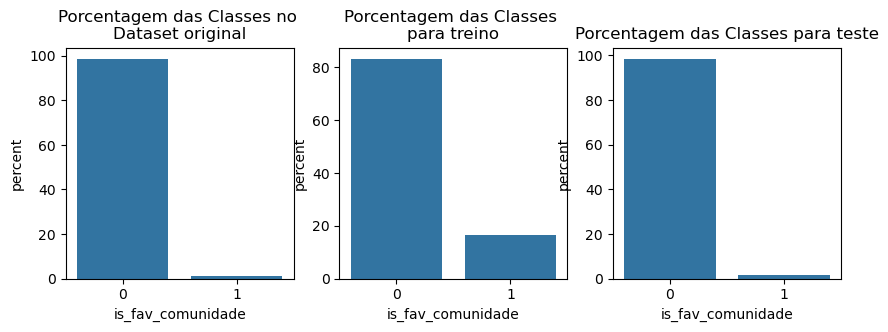

In [96]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()

sns.countplot(pd.DataFrame(y), x="is_fav_comunidade", stat="percent", ax=axes[0]).set(title="Porcentagem das Classes no \nDataset original")
sns.countplot(pd.DataFrame(y_train_b), x="is_fav_comunidade", stat="percent", ax=axes[1]).set(title="Porcentagem das Classes \npara treino")
sns.countplot(pd.DataFrame(y_test), x="is_fav_comunidade", stat="percent", ax=axes[2]).set(title="Porcentagem das Classes para teste")


[Text(0.5, 1.0, 'Porcentagem das Classes para teste')]

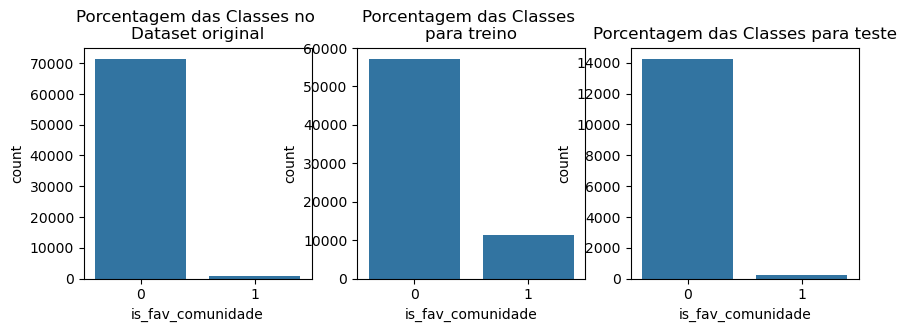

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
axes = axes.flatten()

sns.countplot(pd.DataFrame(y), x="is_fav_comunidade", stat="count", ax=axes[0]).set(title="Porcentagem das Classes no \nDataset original")
sns.countplot(pd.DataFrame(y_train_b), x="is_fav_comunidade", stat="count", ax=axes[1]).set(title="Porcentagem das Classes \npara treino")
sns.countplot(pd.DataFrame(y_test), x="is_fav_comunidade", stat="count", ax=axes[2]).set(title="Porcentagem das Classes para teste")

### Visualizar os distribuições dos dados

In [97]:
from scipy.stats import mannwhitneyu

def check_distribution_similarity_median(df1, df2, alpha=0.05):
    results = {}
    for column in df1.columns:
        if df1[column].dtype in ['int64', 'float64']:  # Apenas variáveis numéricas
            stat, p_value = mannwhitneyu(df1[column], df2[column], alternative='two-sided')
            results[column] = {
                'U_statistic': stat,
                'p_value': p_value,
                'similar_median': p_value > alpha
            }
    return results

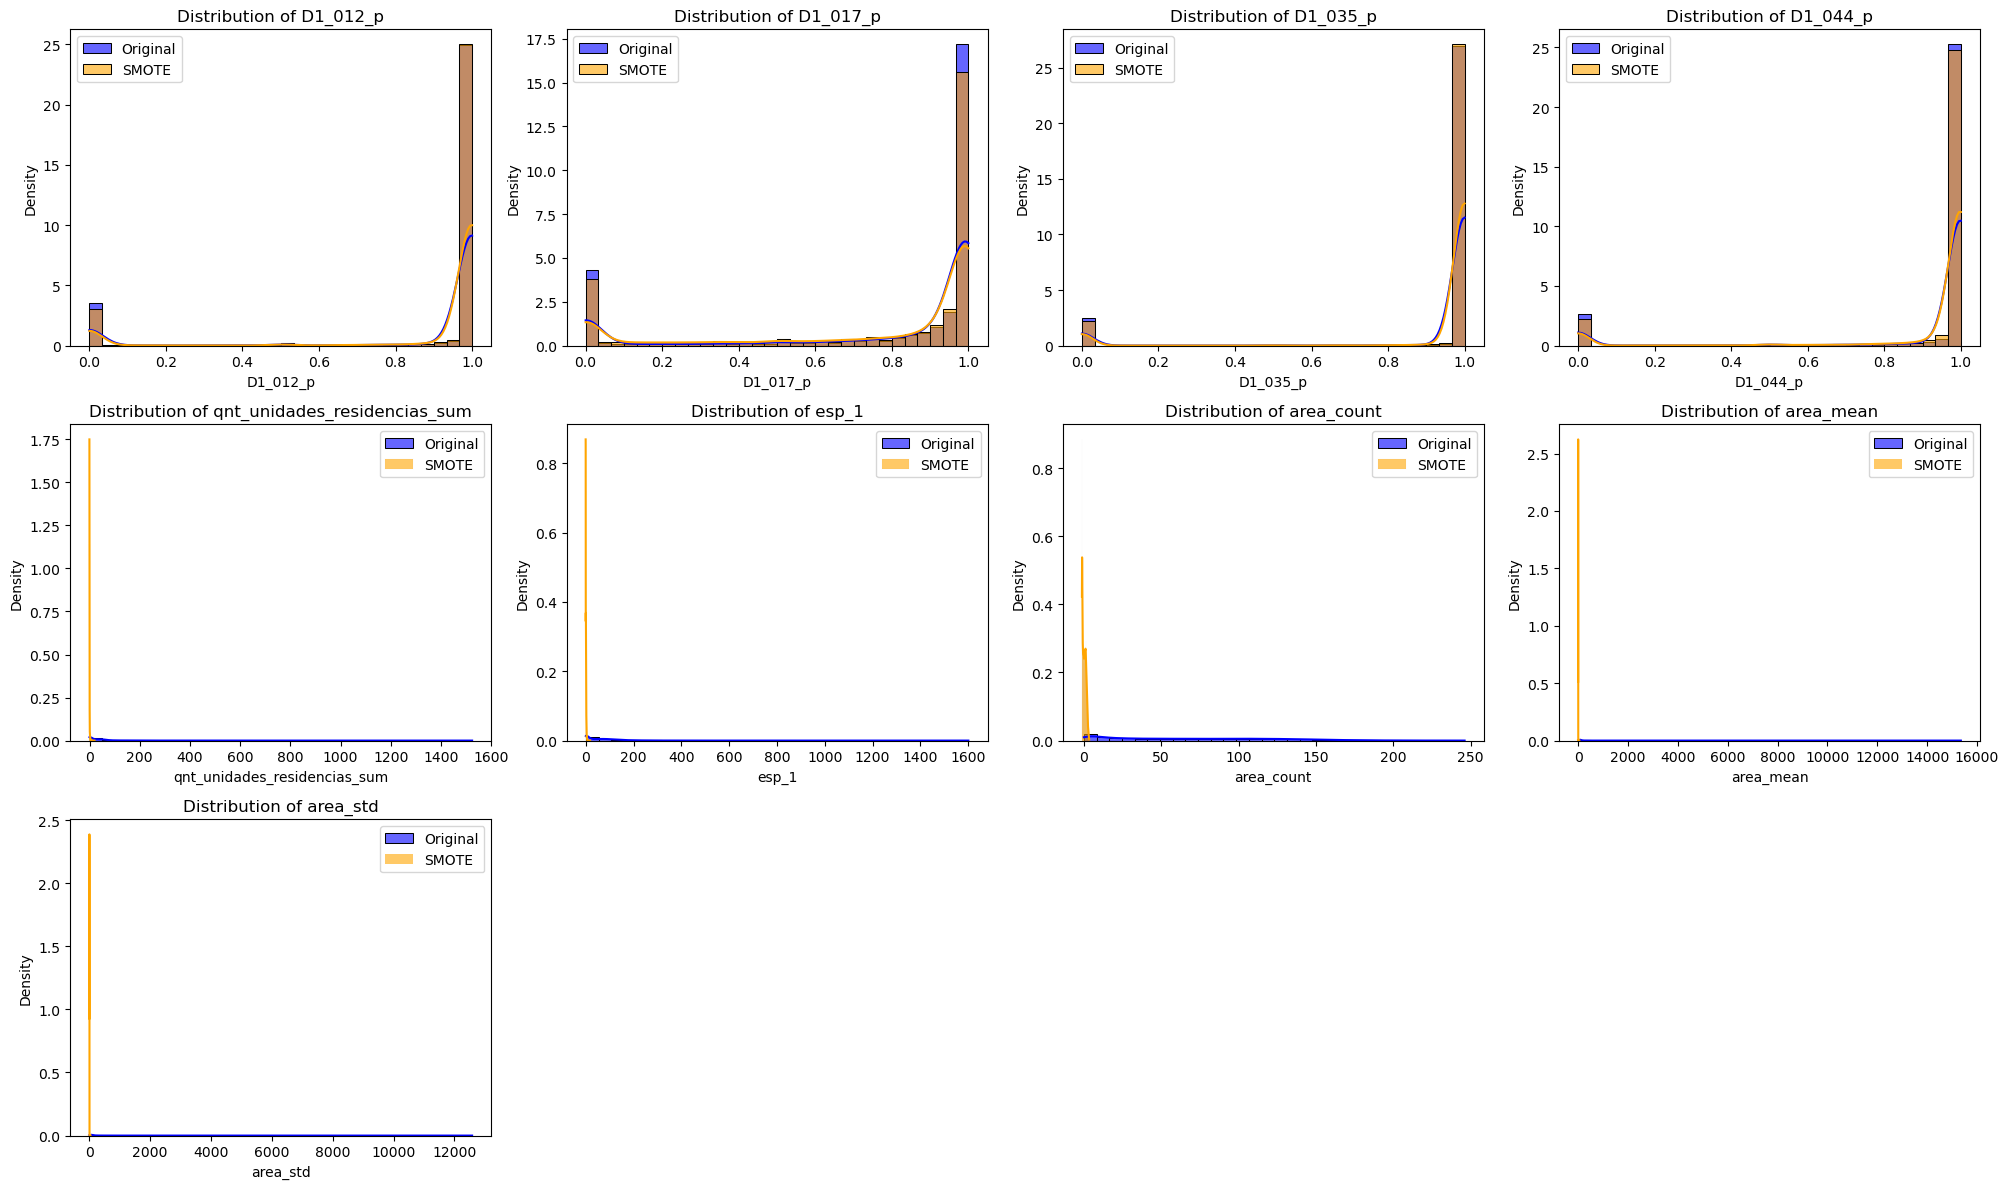

In [98]:
import math

def plot_histogram_grid(original_df, smote_df, bins=30, cols=4):
    num_vars = original_df.select_dtypes(include=['int64', 'float64']).columns
    num_plots = len(num_vars)
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
    axes = axes.flatten()  # Flatten the grid to make iterating easier

    for i, var in enumerate(num_vars):
        sns.histplot(original_df[var], bins=bins, color='blue', kde=True, label='Original', stat="density", alpha=0.6, ax=axes[i])
        sns.histplot(smote_df[var], bins=bins, color='orange', kde=True, label='SMOTE', stat="density", alpha=0.6, ax=axes[i])
        
        axes[i].set_title(f'Distribution of {var}')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Density')
        axes[i].legend()
    
    # Remove any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

# Usage
plot_histogram_grid(X_train, X_train_b)

In [99]:
models = {
    'DecisionTree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'RandomForest': RandomForestClassifier(random_state=RANDOM_STATE),
    'GradientBoosting': GradientBoostingClassifier(random_state=RANDOM_STATE),
    'AdaBoost': AdaBoostClassifier(algorithm='SAMME',random_state=RANDOM_STATE),
    'XGBoost': XGBClassifier(random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'HistGradientBoostingClassifier': HistGradientBoostingClassifier(random_state=RANDOM_STATE),
    #'CatBoostClassifier': CatBoostClassifier(random_state=RANDOM_STATE)
}

In [100]:
results_cv = {}


for name, model in models.items():
    scores = cross_validate(
        model,
        X_train_b,
        y_train_b,
        scoring=('accuracy', 'precision', 'recall', 'roc_auc', 'f1'),
        cv=10,
        return_estimator=True,
        n_jobs=-1)
    results_cv[name] = scores

In [101]:
resultado_simplificado = { }
resultado_simplificado_dp = {}
for key, value in results_cv.items():
  resultado_simplificado[key] =  {
      'accuracy': value['test_accuracy'].mean(),
      'precision': value['test_precision'].mean(),
      'recall' : value['test_recall'].mean(),
      'roc_auc' : value['test_roc_auc'].mean(),
      'f1' : value['test_f1'].mean(),
  }

  resultado_simplificado_dp[key] =  {
      'accuracy': value['test_accuracy'].std(),
      'precision': value['test_precision'].std(),
      'recall' : value['test_recall'].std(),
      'roc_auc' : value['test_roc_auc'].std(),
      'f1' : value['test_f1'].std(),
  }

  print(f"{key} CV accuracy: {resultado_simplificado[key]['accuracy']} ± {resultado_simplificado_dp[key]['accuracy']}")
  print(f"{key} CV precision: {resultado_simplificado[key]['precision']} ± {resultado_simplificado_dp[key]['precision']}")
  print(f"{key} CV recall: {resultado_simplificado[key]['recall']} ± {resultado_simplificado_dp[key]['recall']}")
  print(f"{key} CV roc_auc: {resultado_simplificado[key]['roc_auc']} ± {resultado_simplificado_dp[key]['roc_auc']}")
  print(f"{key} CV f1: {resultado_simplificado[key]['f1']} ± {resultado_simplificado_dp[key]['f1']}")




DecisionTree CV accuracy: 0.9693679655645084 ± 0.007621716819201539
DecisionTree CV precision: 0.9016237949908115 ± 0.007564339607145487
DecisionTree CV recall: 0.9159213821113384 ± 0.0451982928847787
DecisionTree CV roc_auc: 0.9508322041220214 ± 0.023597807049395514
DecisionTree CV f1: 0.9082404473127994 ± 0.02620823038248236
RandomForest CV accuracy: 0.9850117905789508 ± 0.006694035396883105
RandomForest CV precision: 0.9516230488688834 ± 0.005046230786701303
RandomForest CV recall: 0.9588327938437109 ± 0.041860234821169254
RandomForest CV roc_auc: 0.997619890715321 ± 0.001511397390490501
RandomForest CV f1: 0.9547268600365768 ± 0.022240522495628582
GradientBoosting CV accuracy: 0.950446682079105 ± 0.007518643982563293
GradientBoosting CV precision: 0.8659578043983721 ± 0.01190232535257859
GradientBoosting CV recall: 0.8308836687330139 ± 0.040577305105331814
GradientBoosting CV roc_auc: 0.9847342110519233 ± 0.003757051876847089
GradientBoosting CV f1: 0.8477404681531915 ± 0.027045505

In [102]:
mean_results = pd.DataFrame(resultado_simplificado)
std_results = pd.DataFrame(resultado_simplificado_dp)

In [103]:
mean_results.head()

,DecisionTree,RandomForest,GradientBoosting,AdaBoost,XGBoost,KNN,HistGradientBoostingClassifier
accuracy,0.969368,0.985012,0.950447,0.928423,0.979331,0.967693,0.970009
precision,0.901624,0.951623,0.865958,0.817911,0.933818,0.852065,0.904979
recall,0.915921,0.958833,0.830884,0.733959,0.942665,0.975616,0.916359
roc_auc,0.950832,0.997620,0.984734,0.968522,0.996949,0.990273,0.994210
f1,0.908240,0.954727,0.847740,0.773401,0.937763,0.909644,0.910018


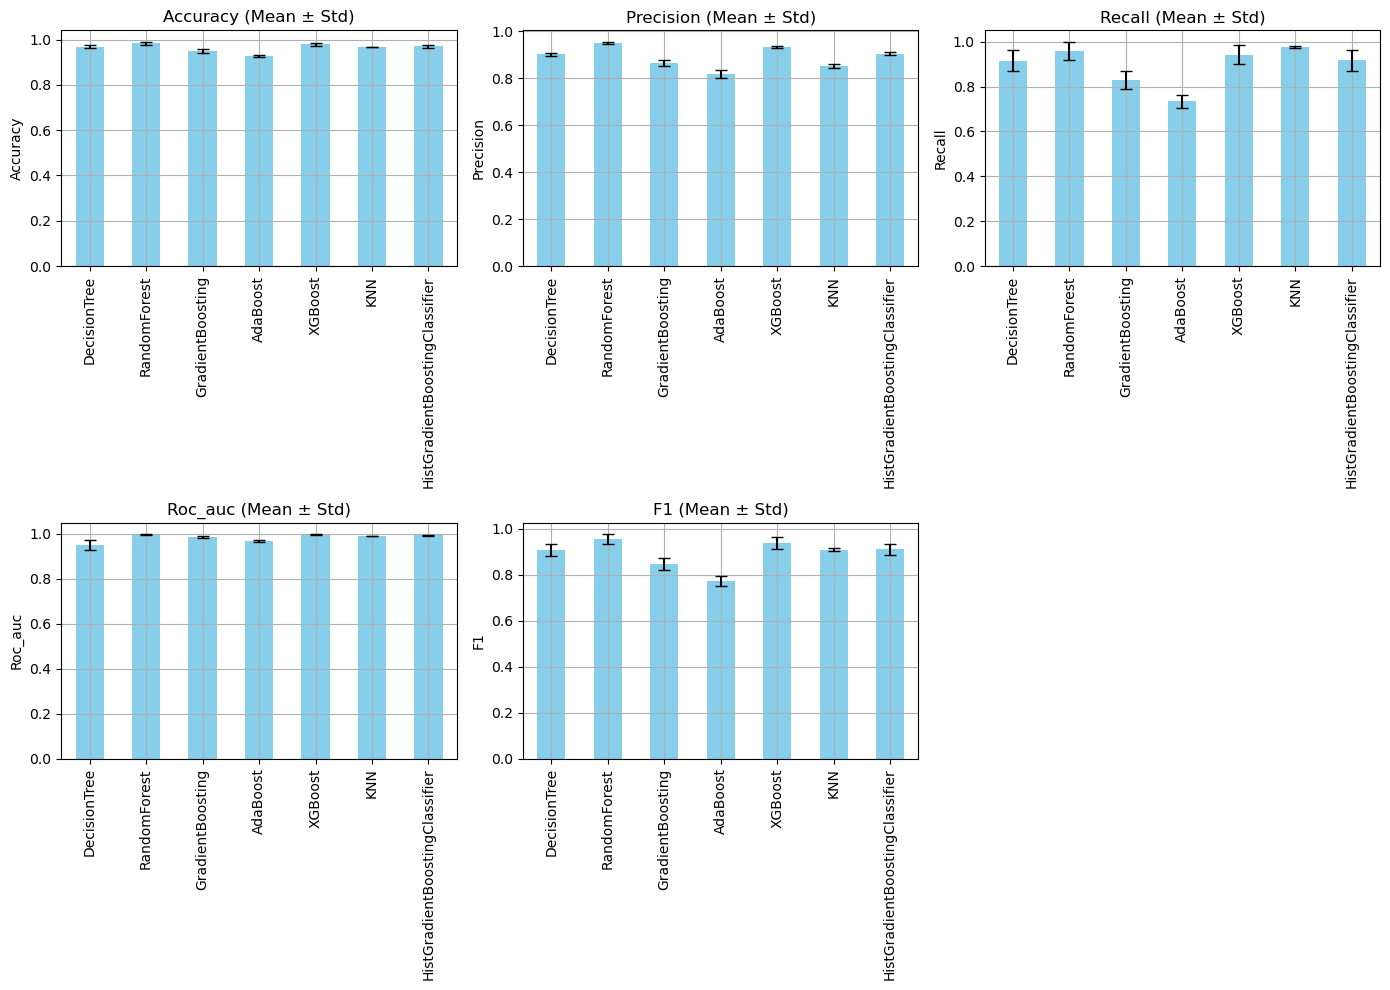

In [104]:
# Plotando a média e o desvio padrão lado a lado
fig, axes = plt.subplots(2, 3, figsize=(14, 10))
axes = axes.flatten()
metrics = ['accuracy', 'precision', 'recall', 'roc_auc', 'f1']

for i, metric in enumerate(metrics):
    ax = axes[i]
    mean_values = mean_results.loc[metric]
    std_values = std_results.loc[metric]
    
    mean_values.plot(kind='bar', yerr=std_values, ax=ax, capsize=4, color='skyblue')
    ax.set_title(f'{metric.capitalize()} (Mean ± Std)')
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)

# Hide any unused axes
for j in range(len(metrics), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [105]:
from scipy.stats import ttest_rel

# Define the models to compare (DecisionTree and XGBoost)
models_to_test = ['DecisionTree', 'XGBoost', 'RandomForest']

# Create an empty list to store the test results
results_list = []

# Function to perform the paired t-test and append results to the list
def perform_t_test(reference_model, target_model, metric='test_roc_auc'):
    ref_scores = results_cv[reference_model][metric]
    target_scores = results_cv[target_model][metric]
    
    # Perform paired t-test
    t_stat, p_value = ttest_rel(ref_scores, target_scores)
    
    # Determine whether to reject the null hypothesis
    confidence_level = 0.95
    significant = 'Yes' if p_value < (1 - confidence_level) else 'No'
    
    # Append the result to the list
    results_list.append({
        'Reference Model': reference_model,
        'Compared Model': target_model,
        'Metric': metric,
        'T-statistic': t_stat,
        'P-value': p_value,
        'Significant Difference (95%)': significant
    })

# Loop through all models and compare with DecisionTree and XGBoost
for ref_model in models_to_test:
    for model_name in results_cv.keys():
        if model_name != ref_model:  # Avoid comparing the model with itself
            perform_t_test(ref_model, model_name, 'test_recall')

# Convert the results list to a DataFrame
results_df = pd.DataFrame(results_list)

# Display the DataFrame




In [230]:
results_df

,Reference Model,Compared Model,Metric,T-statistic,P-value,Significant Difference (95%)
0,DecisionTree,RandomForest,test_recall,-11.480664,1.121401e-06,Yes
1,DecisionTree,GradientBoosting,test_recall,18.292562,1.991759e-08,Yes
2,DecisionTree,AdaBoost,test_recall,17.683624,2.681069e-08,Yes
3,DecisionTree,XGBoost,test_recall,-9.263901,6.736234e-06,Yes
4,DecisionTree,KNN,test_recall,-3.703462,4.894259e-03,Yes
5,DecisionTree,HistGradientBoostingClassifier,test_recall,-1.566847,1.515931e-01,No
6,XGBoost,DecisionTree,test_recall,9.263901,6.736234e-06,Yes
7,XGBoost,RandomForest,test_recall,-2.935728,1.660164e-02,Yes
8,XGBoost,GradientBoosting,test_recall,18.623046,1.701725e-08,Yes
9,XGBoost,AdaBoost,test_recall,17.475485,2.974372e-08,Yes


# Melhor modelo?

- RandomForest, tem melhor Recall (Evita Falso-Positive)
- RandomForest Tem melhor F1 (balanço entre falso-positivo e a AUC)

In [106]:
def model_eval(model,X_train,y_train,X_test,y_test,classes=None,
                           normalize='true',cmap='Blues',label=''):

    """Example function with PEP 484 type annotations.

        Args:
            model: The Model Classifier.
            X_train: X_train being used to fit model (could be scaled or not).
            y_train: y_train being used to fit model and to get train accuracy.
            X_test: X_test to get test predictions.
            y_test: y_test used to get test accuracy

        Returns:
            Model Accuracy. Confusion Matrix, ROC Curve, and best params for GridSearch

    """
    
    
    #FITTING MODEL WITH TRAIN DATA
    model.fit(X_train,y_train)   
      
    #GETTING TRAIN PREDICTIONS
    y_hat_train = model.predict(X_train)
    
    #GETING TEST PREDICTIONS
    y_hat_test = model.predict(X_test)
    
    dashes = '---'*20
    
    if isinstance(model,GridSearchCV):
        grid_header = "GRID SEARCH FOUND THE FOLLOWING OPTIMAL PARAMETERS: "
        print(dashes,grid_header,dashes,sep='\n')
        best_parameters = model.best_params_
        for param_name in sorted(best_parameters.keys()):
            print("%s: %r" % (param_name, best_parameters[param_name]))
    
    #GETTING ACCURACY SCORE FOR TRAIN AND TEST
    
    if len(label)>0:
        accuracy_header = f'{label} ACCURACY'
    else:
        accuracy_header = 'MODEL ACCURACY'
    print(dashes,accuracy_header,dashes,sep='\n')
    training_accuracy = accuracy_score(y_train, y_hat_train)
    testing_accuracy = accuracy_score(y_test, y_hat_test)
    
    print(f'TRAINING ACCURACY: {round(training_accuracy*100,2)}%')
    print(f'TESTING ACCURACY: {round(testing_accuracy*100,2)}%')
          
    #CLASSIFICATION REPORT AND SCORES
    test_header = "CLASSIFICATION REPORT"
    
    #ADDING LABEL IF GIVEN
    if len(label)>0:
        test_header += f" USING {label}"
    
    # PRINT CLASSIFICATION REPORT
    
    print(dashes,test_header,dashes,sep='\n')

    print(classification_report(y_test,y_hat_test,
                                    target_names=classes))

    print(dashes+"\n\n")
    
    

    # MAKE FIGURE
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    # PLOTTING CONFUSION MATRIX 

    
    #cm = confusion_matrix(, labels=model.classes_)
    ConfusionMatrixDisplay.from_predictions(y_test, y_hat_test, labels=model.classes_, ax=axes[0], cmap=cmap)
    axes[0].set(title='Confusion Matrix')
    
    #PLOTTING ROC CURVE
    fpr, tpr, thresholds = roc_curve(y_test, y_hat_test)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay.from_predictions(y_test, y_hat_test, ax=axes[1])
    axes[1].set_title('Receiving Operator Characteristic (ROC) Curve') 
    #fig.tight_layout()
    
    
    plt.show()


## Hiperparâmetros Para Decision Tree


In [397]:
param_grid_decision_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [10, 50],
    'splitter': ['best', 'random'],
    'class_weight': [None, 'balanced']
}

In [398]:
grid_search_decision_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_grid_decision_tree,
    cv=10,
    scoring='recall')
grid_search_decision_tree.fit(X_train_standScaler, y_train)

print("Melhores parametros Para  DecisionTreeClassifier:", grid_search_decision_tree.best_params_)
print("Melhor CV recall para DecisionTreeClassifier:", grid_search_decision_tree.best_score_)

Melhores parametros Para  DecisionTreeClassifier: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
Melhor CV recall para DecisionTreeClassifier: 0.9397260273972602


/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [406]:
grid_search_decision_tree_f1 = GridSearchCV(
    DecisionTreeClassifier(random_state=1),
    param_grid_decision_tree,
    cv=10,
    scoring='f1')
grid_search_decision_tree_f1.fit(X_train_standScaler, y_train)

print("Melhores parametros Para  DecisionTreeClassifier:", grid_search_decision_tree_f1.best_params_)
print("Melhor CV F1 para DecisionTreeClassifier:", grid_search_decision_tree_f1.best_score_)

Melhores parametros Para  DecisionTreeClassifier: {'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': 50, 'min_samples_leaf': 5, 'min_samples_split': 20, 'splitter': 'best'}
Melhor CV F1 para DecisionTreeClassifier: 0.2599772875894943


In [407]:
model_decision_tree = grid_search_decision_tree.best_estimator_
model_decision_tree_f1 = grid_search_decision_tree_f1.best_estimator_


### Metrics

#### Recal

------------------------------------------------------------
Decision Tree ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 43.02%
TESTING ACCURACY: 43.18%
------------------------------------------------------------
CLASSIFICATION REPORT USING Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     15568
           1       0.02      0.93      0.04       177

    accuracy                           0.43     15745
   macro avg       0.51      0.68      0.32     15745
weighted avg       0.99      0.43      0.59     15745

------------------------------------------------------------




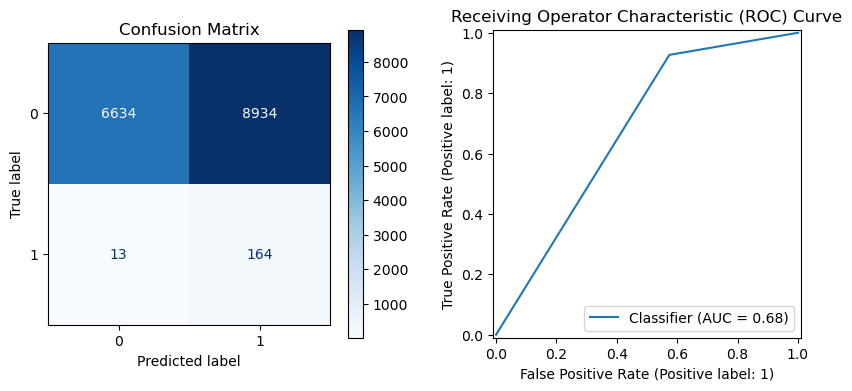

In [400]:
model_eval(model_decision_tree,X_train_standScaler, y_train, X_test_standScaler, y_test,label='Decision Tree')

------------------------------------------------------------
Decision Tree ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 99.02%
TESTING ACCURACY: 98.87%
------------------------------------------------------------
CLASSIFICATION REPORT USING Decision Tree
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     15568
           1       0.49      0.24      0.32       177

    accuracy                           0.99     15745
   macro avg       0.74      0.62      0.66     15745
weighted avg       0.99      0.99      0.99     15745

------------------------------------------------------------




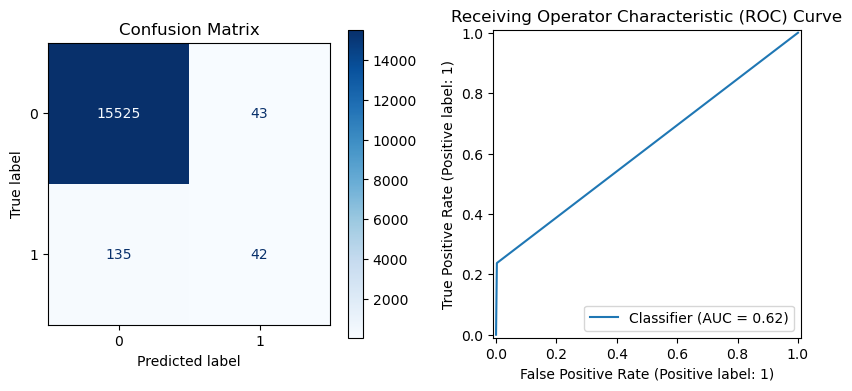

In [408]:
model_eval(model_decision_tree_f1,X_train_standScaler, y_train, X_test_standScaler, y_test,label='Decision Tree')

## Variaveis da Decision Tree

### Recal

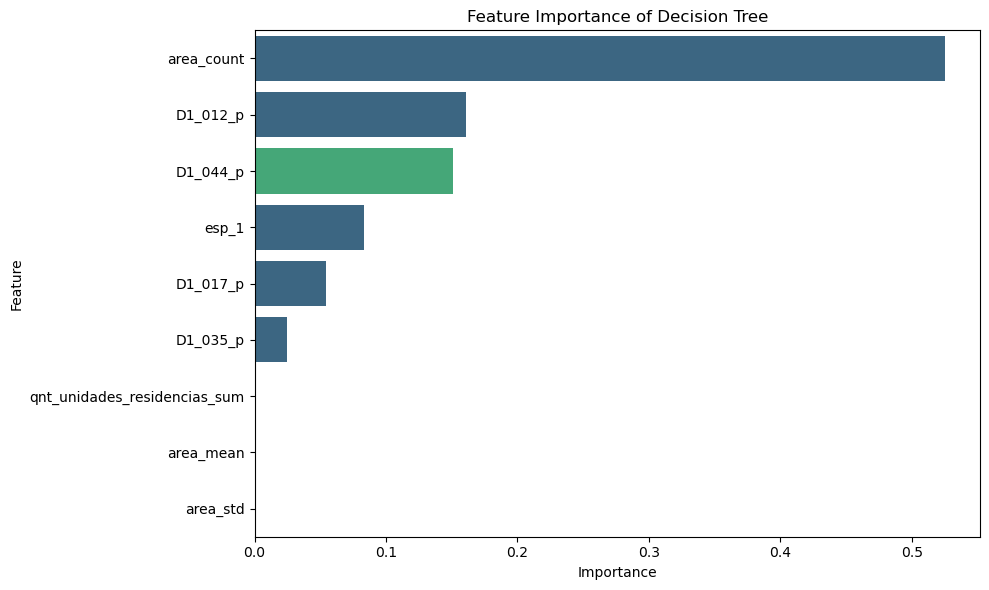

In [402]:
importances = model_decision_tree.feature_importances_
features = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame for better plotting
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis', hue=y, legend=False, order=feature_importances['Feature'])

plt.title('Feature Importance of Decision Tree')
plt.tight_layout()
plt.show()

In [403]:
#CALLING SHAP TREE EXPLAINER
explainer = shap.TreeExplainer(model_decision_tree)
#GETTING SHAP VALUES
shap_values = explainer.shap_values(X_train_standScaler)
#INITIATING SHAP
shap.initjs()

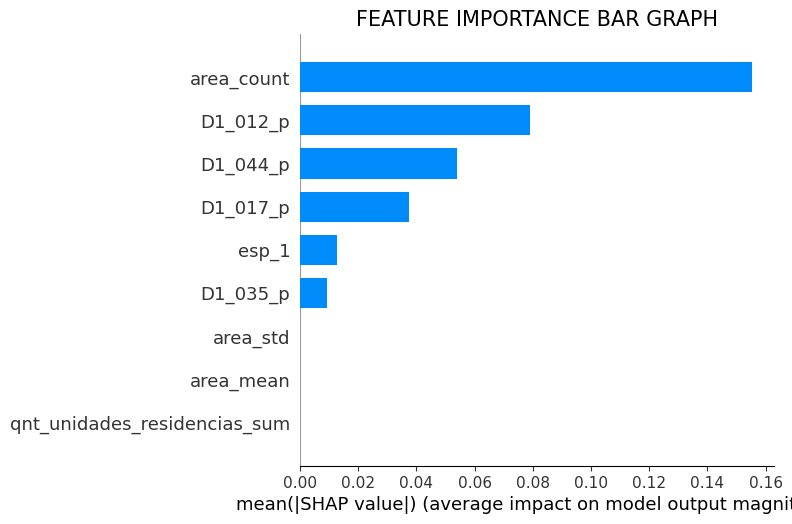

In [404]:
#PLOTTING MOST IMPORTATANT FEATURES
shap.summary_plot(shap_values[:, :, 0], X_train_standScaler, plot_type="bar", show=False)
plt.title('FEATURE IMPORTANCE BAR GRAPH',fontsize = 15)
plt.show()

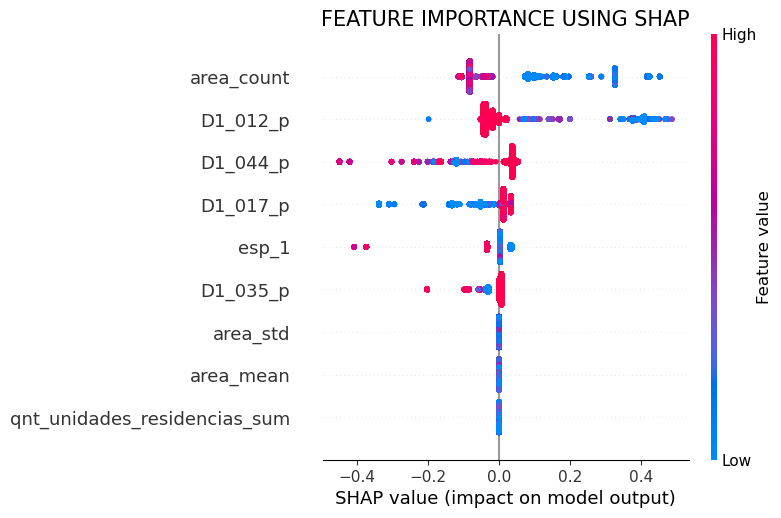

In [405]:
shap.summary_plot(shap_values[:, :, 0], X_train_standScaler,show=False)
plt.title('FEATURE IMPORTANCE USING SHAP',fontsize = 15)
plt.show()

### F1

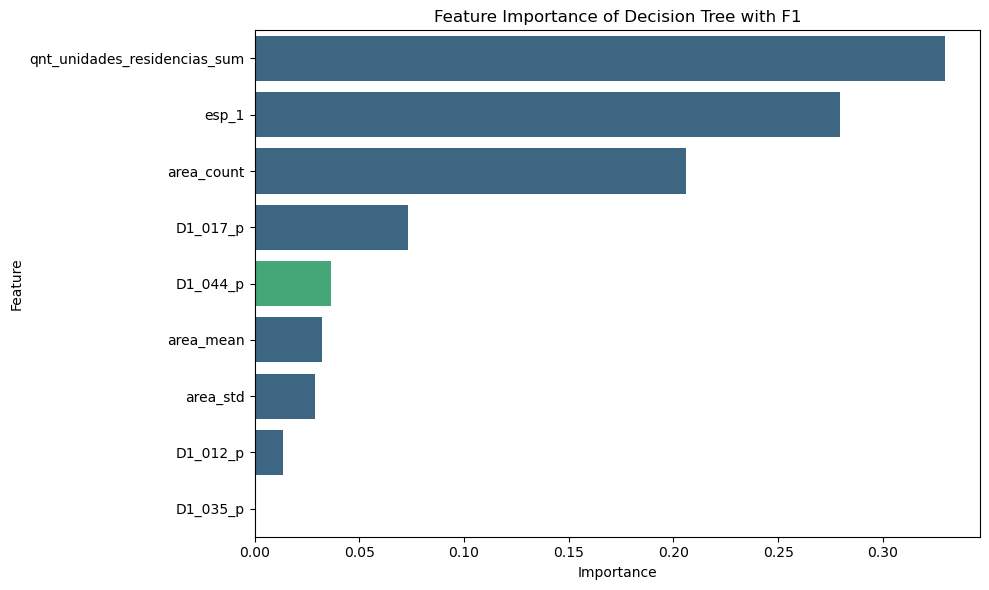

In [411]:
importances = model_decision_tree_f1.feature_importances_
features = X_train.columns  # Assuming X_train is a pandas DataFrame

# Create a DataFrame for better plotting
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importances})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, palette='viridis', hue=y, legend=False, order=feature_importances['Feature'])

plt.title('Feature Importance of Decision Tree with F1')
plt.tight_layout()
plt.show()

## Hiperparâmetros Para RandomForestClassifier


In [107]:
param_grid_random_forest = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [10, 50],
    'class_weight': [None, 'balanced']
}

param_grid_random_forest = {
    'class_weight': [None, 'balanced'],
   
}

In [108]:
grid_search_RandomForest = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE),
    param_grid_random_forest,
    cv=10,
    scoring='recall',
    n_jobs=-1,
    verbose=3
    )
grid_search_RandomForest.fit(X_train_b, y_train_b)

print("Melhores parametros Para  RandomForestClassifier:", grid_search_RandomForest.best_params_)
print("Melhor CV recall para RandomForestClassifier:", grid_search_RandomForest.best_score_)

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV 1/10] END ................class_weight=None;, score=0.834 total time=  17.0s
[CV 2/10] END ................class_weight=None;, score=0.972 total time=  17.2s
[CV 3/10] END ................class_weight=None;, score=0.981 total time=  17.3s
[CV 8/10] END ................class_weight=None;, score=0.976 total time=  17.1s
[CV 4/10] END ................class_weight=None;, score=0.976 total time=  17.3s
[CV 9/10] END ................class_weight=None;, score=0.965 total time=  17.2s
[CV 5/10] END ................class_weight=None;, score=0.969 total time=  17.4s
[CV 6/10] END ................class_weight=None;, score=0.975 total time=  17.3s
[CV 7/10] END ................class_weight=None;, score=0.969 total time=  17.4s
[CV 10/10] END ...............class_weight=None;, score=0.973 total time=  17.4s
[CV 2/10] END ............class_weight=balanced;, score=0.969 total time=  17.9s
[CV 1/10] END ............class_weight=balanced;

In [109]:
model_grid_search_RandomForest = grid_search_RandomForest.best_estimator_

------------------------------------------------------------
RandomForest ACCURACY
------------------------------------------------------------
TRAINING ACCURACY: 99.87%
TESTING ACCURACY: 97.9%
------------------------------------------------------------
CLASSIFICATION REPORT USING RandomForest
------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     14276
           1       0.32      0.45      0.37       203

    accuracy                           0.98     14479
   macro avg       0.66      0.72      0.68     14479
weighted avg       0.98      0.98      0.98     14479

------------------------------------------------------------




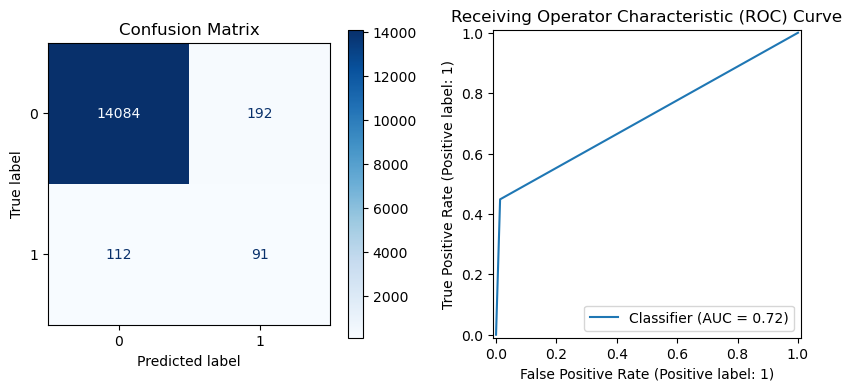

In [110]:
model_eval(model_grid_search_RandomForest,X_train_b, y_train_b, X_test_standScaler, y_test,label='RandomForest')

## Get models results

In [113]:
x_all = apply_standard_scaler(standScaler, X, ['qnt_unidades_residencias_sum', 'esp_1', 'area_count', 'area_mean', 'area_std'])

In [115]:
y_all_hat = model_grid_search_RandomForest.predict_proba(x_all)

In [116]:
x_all.shape

(72393, 9)

In [131]:
sao_remo_poli = dados[dados['id_hex'] == '8aa81005aadffff'].index[0]
oscar_freire = dados[dados['id_hex'] == '8aa8100ea147fff'].index[0]

buracana = dados[dados['id_hex'] == '8aa81005aa8ffff'].index[0]

test = dados[dados['id_hex'] == '8aa8103b4a37fff'].index[0]

In [132]:
y_all_hat[test]

array([0.545, 0.455])

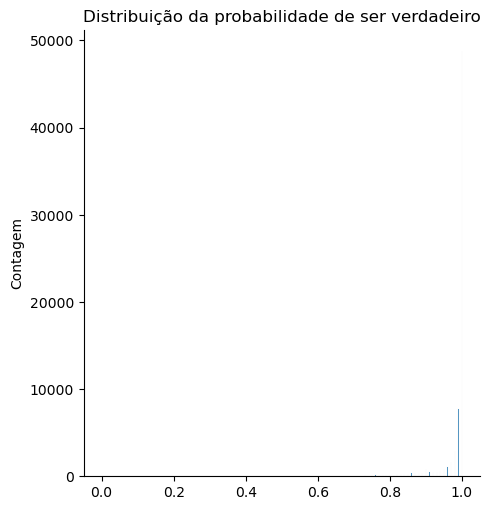

In [137]:
sns.displot(y_all_hat[:, 0]). set(title='Distribuição da probabilidade de ser verdadeiro', ylabel='Contagem')


### Shap teste

In [278]:
explainer = shap.TreeExplainer(model_grid_search_RandomForest)


In [275]:
explainer.expected_value

array([0.83616667, 0.16383333])

In [280]:
shap_values = explainer(x_all)

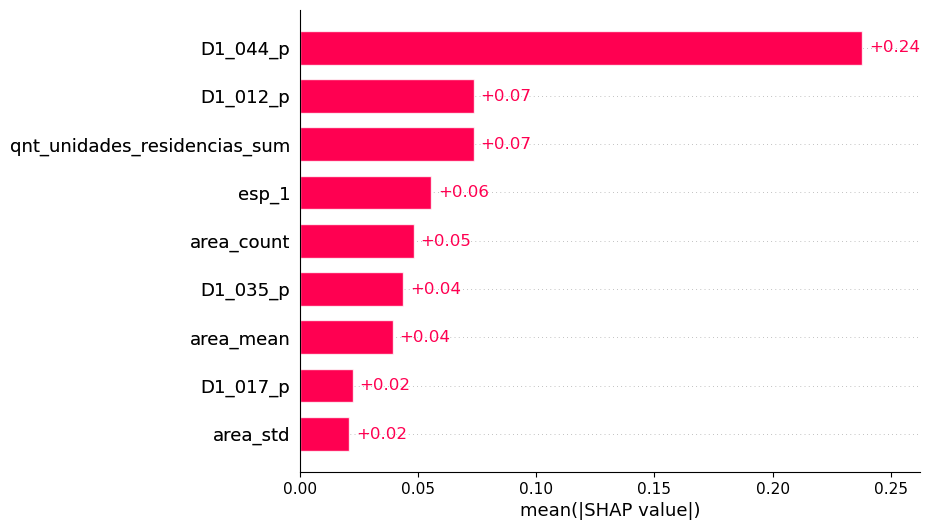

In [281]:
shap.plots.bar(shap_values[:, :, 1])

In [282]:
#clustering
clustering = shap.utils.hclust(x_all, y)



/opt/anaconda3/envs/scriptsMestrado/lib/python3.12/site-packages/shap/utils/_clustering.py:126: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).
  warnings.warn(f"No/low signal found from feature {i} (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all distances to 1).")
10it [00:15,  3.96s/it]                      


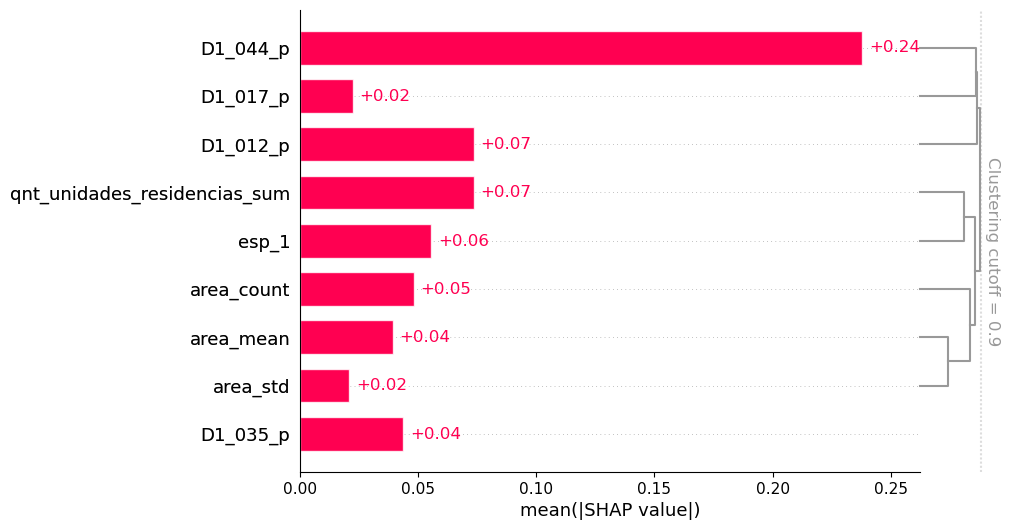

In [285]:
shap.plots.bar(shap_values[:, :, 1], clustering=clustering,  clustering_cutoff=0.9)

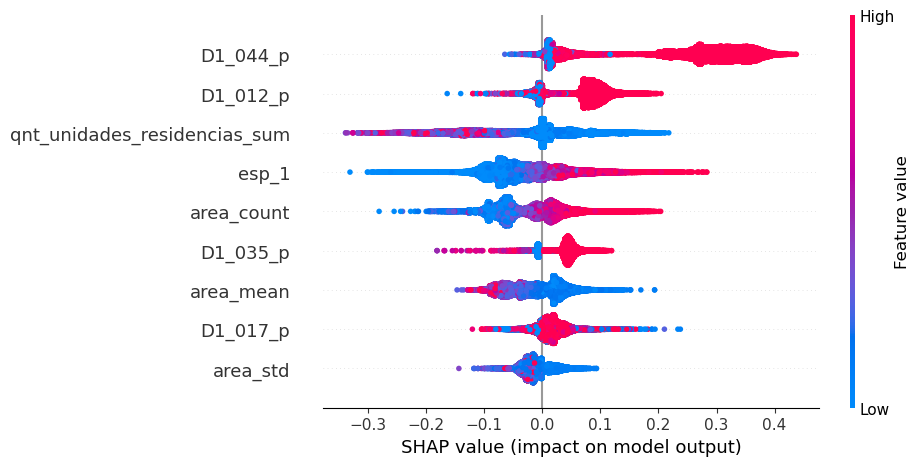

In [286]:
shap.plots.beeswarm(shap_values[:, :, 1])

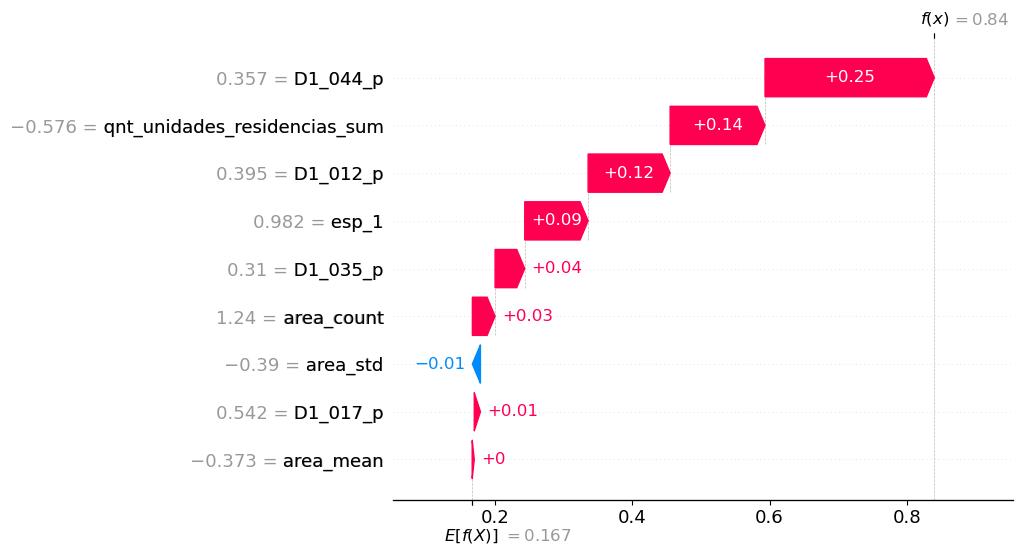

In [287]:
# São Remo poligono 
shap.plots.waterfall(shap_values[buracana, :, 1])

In [288]:
shap.force_plot(explainer.expepcted_value[1], shap_values[sao_remo_poli, :, 1].values, feature_names=(x_all.columns))

In [146]:
shap.force_plot(explainer.expected_value[1], shap_values[buracana, :, 1].values, feature_names=(x_all.columns))

NameError: name 'explainer' is not defined

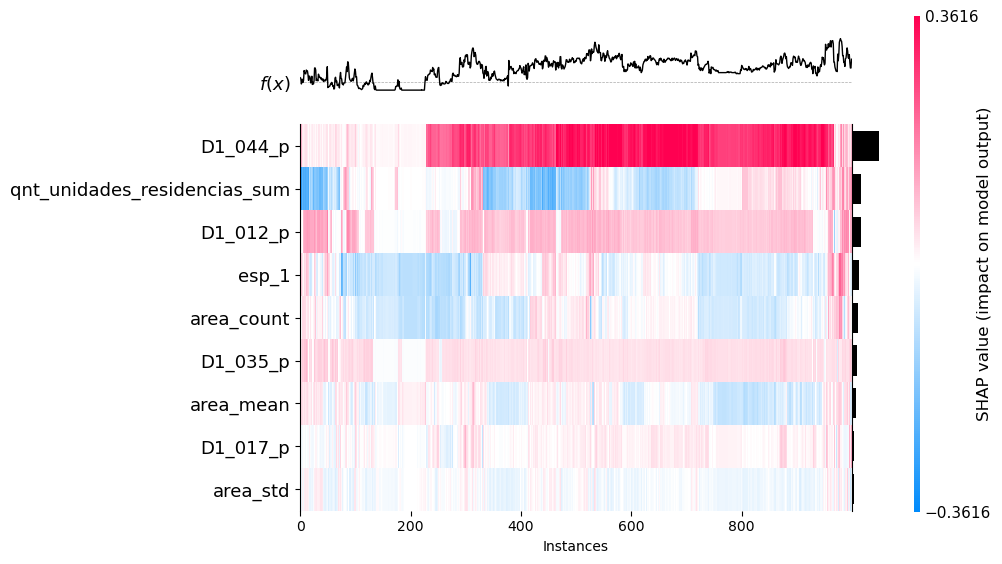

<Axes: xlabel='Instances'>

In [290]:
shap.plots.heatmap(shap_values[:1000, : , 1])

In [292]:
condition_outlier = y_all_hat[: , 1] >= 0.5
qnt_pred_as_true = condition_outlier.sum()

true_pred =  sum(y[y_all_hat[: , 1] >= 0.5])

print(qnt_pred_as_true, true_pred)

29545 850


In [124]:
T = x_all[(y_all_hat[:, 1] >=0.5) & (y == 0)]

In [140]:
falso_positivo_condition = ((y_all_hat[:, 1] >=0.5) & (y == 0))
falso_negativo_condition = (y_all_hat[:, 1]  <0.5) & (y == 1)
true_condition = (y_all_hat[:, 1]  >= 0.5) & (y == 1)
false_condition = (y_all_hat[:, 1] < 0.5) & (y == 0)


In [293]:
# Analise falso positivo
T = x_all[falso_positivo_condition]
sh = explainer(T)


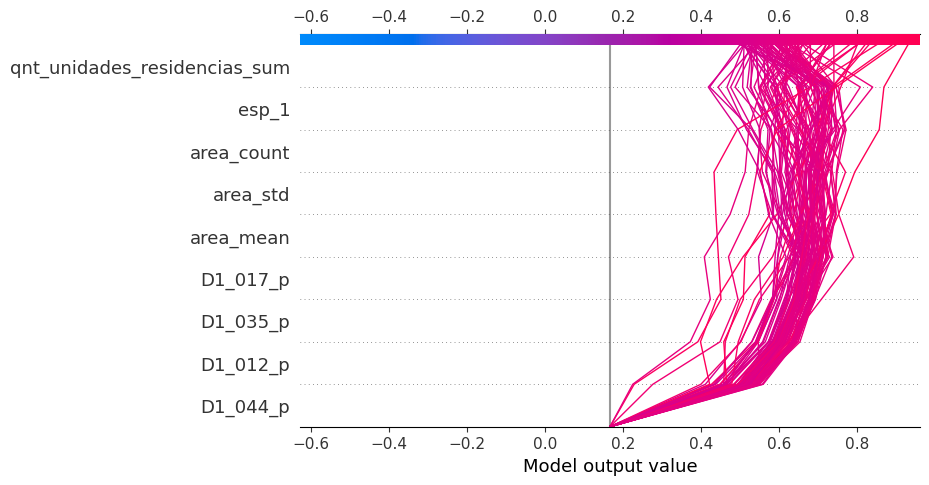

In [294]:
with warnings.catch_warnings():
    r = shap.decision_plot(explainer.expected_value[1], sh[:100, :, 1].values, T[:100], feature_order="hclust", return_objects=True, ignore_warnings=True)

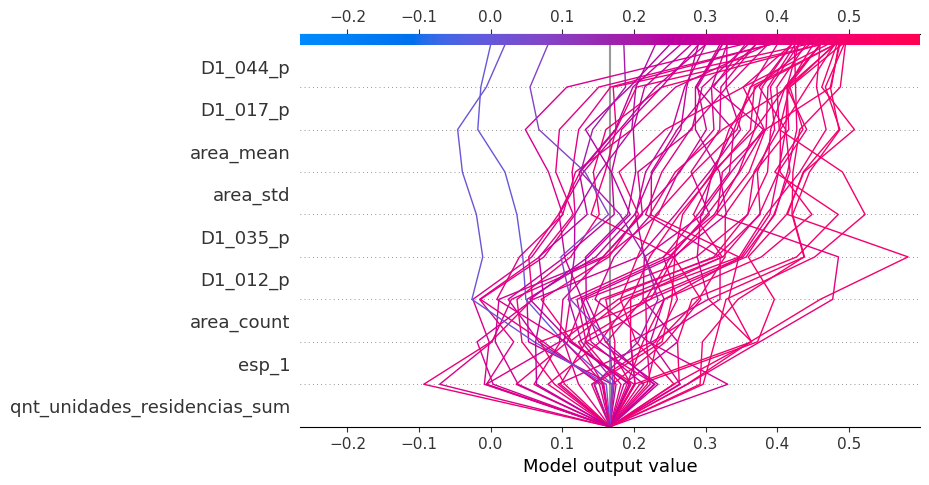

In [302]:
with warnings.catch_warnings():
    r = shap.decision_plot(explainer.expected_value[1], sh[:, :, 1].values, T, feature_order="hclust", return_objects=True, ignore_warnings=True)

In [296]:
# Analise falso negativo
T = x_all[falso_negativo_condition]
sh = explainer(T)


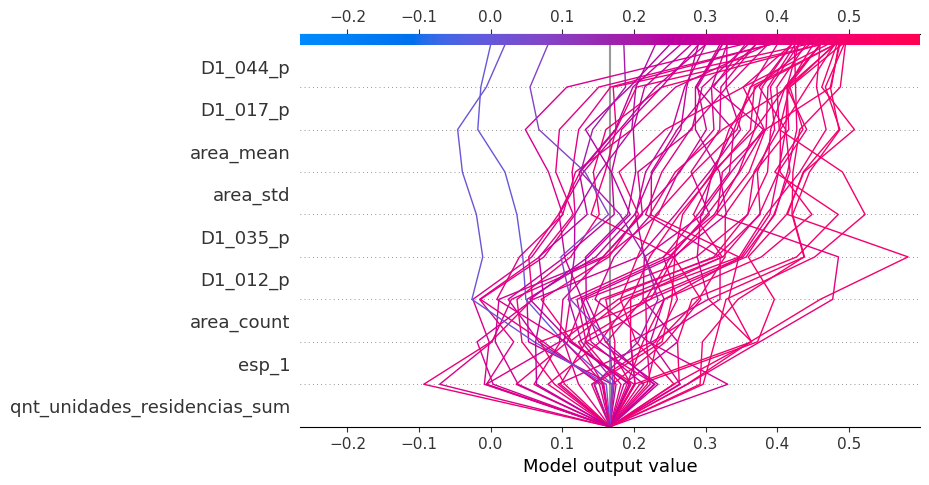

In [297]:
r = shap.decision_plot(explainer.expected_value[1], sh[:, :, 1].values, T, feature_order="hclust", return_objects=True)

## Saving probability and classification

In [143]:
dados['is_fav_prob_model1'] = y_all_hat[:, 1]

In [144]:

dados.loc[falso_positivo_condition, 'model1_result'] = 'FP'
dados.loc[falso_negativo_condition, 'model1_result'] = 'FN'
dados.loc[true_condition, 'model1_result'] = 'P'
dados.loc[false_condition, 'model1_result'] = 'N'




In [145]:
dados.to_file("data/generate/WGS84_hex_sp_model1_test.gpkg", driver="GPKG")